# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import timeit

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

In [2]:
#%%pycodestyle


class MyKmeans:    
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', tol=1e-4):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.tol = tol

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        # Массив с центройдами кластеров
        if self.init == 'k-means':
            self.centroids = np.empty((self.k, X.shape[1]))
            self.centroids[0] = X[np.random.choice(X.shape[0])]
            for c in np.arange(1, self.k):
                euc = MyKmeans.euclid(X, self.centroids[:c, :]).min(axis=1)
                euc /= euc.sum()
                self.centroids[c] = X[np.random.choice(X.shape[0],
                                                       replace=False, p=euc)]
        elif self.init == 'random':
            self.centroids = X[np.random.choice(X.shape[0],
                                                replace=False, size=self.k)]
        centroids = np.empty(self.centroids.shape)
        for it in np.arange(self.max_iter):
            self.labels = MyKmeans.euclid(X, self.centroids).argmin(axis=1)
            for c in np.arange(self.k):
                if np.any(self.labels == c, axis=0):
                    centroids[c] = np.mean(X[self.labels == c], axis=0)
                else:
                    centroids[c] = X[np.random.choice(X.shape[0])]
            if np.all(np.abs(centroids - self.centroids) < self.tol):
                break
            centroids, self.centroids = self.centroids, centroids
        return self

    def euclid(X, Y):
        ret_euc = (X ** 2).sum(axis=1).reshape(-1, 1) - 2 * (X.dot(Y.T)) + (Y ** 2).sum(axis=1)
        ret_euc[ret_euc < 0] = 0
        return np.sqrt(ret_euc)

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        Возвращает метку ближайшего кластера для каждого объекта
        """
        return MyKmeans.euclid(X, self.centroids).argmin(axis=1)


class MiniBatchKMeans(MyKmeans):
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random',
                 batch_size=5, tol=1e-4):
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.batch_size = batch_size
        self.tol = tol

    def __fit__(self, X, y=None):
        """
        Процедура обучения k-means
        """
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        # Массив с центройдами кластеров
        if self.init == 'k-means':
            self.centroids = np.empty((self.k, X.shape[1]))
            self.centroids[0] = X[np.random.choice(X.shape[0])]
            for c in np.arange(1, self.k):
                euc = MyKmeans.euclid(X,
                                      self.centroids[:c, :]).min(axis=1)
                euc /= euc.sum()
                self.centroids[c] = X[np.random.choice(X.shape[0],
                                            replace=False, p=euc)]
        elif self.init == 'random':
            self.centroids = X[np.random.choice(X.shape[0],
                                                replace=False,
                                                size=self.k)]
        centroids = np.empty((self.k, X.shape[1]))
        for it in np.arange(self.max_iter):
            tmp = X[np.random.choice(X.shape[0], replace=False,
                                     size=min(self.batch_size, X.shape[0]))]
            self.labels = MyKmeans.euclid(tmp,
                                          self.centroids).argmin(axis=1)
            for c in np.arange(self.k):
                if np.any(self.labels == c, axis=0):
                    centroids[c] = np.mean(tmp[self.labels == c], axis=0)
                else:
                    centroids[c] = tmp[np.random.choice(tmp.shape[0])]
            if np.all(np.abs(centroids - self.centroids) < self.tol):
                break
            centroids, self.centroids = self.centroids, centroids

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        Возвращает метку ближайшего кластера для каждого объекта
        """
        return MyKmeans.euclid(X, self.centroids).argmin(axis=1)

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs

In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

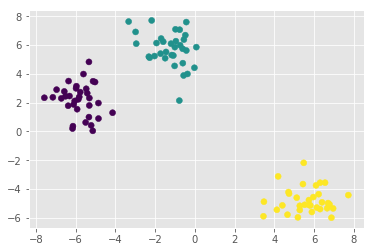

In [5]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

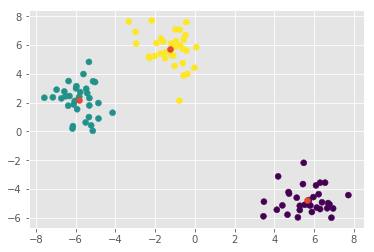

In [10]:
## Работоспособность MyKmeans
mk = MyKmeans(k=3)
mk.fit(X)
plt.scatter(X[:, 0], X[:, 1], c = mk.predict(X))
plt.scatter(mk.centroids[:, 0], mk.centroids[:, 1])

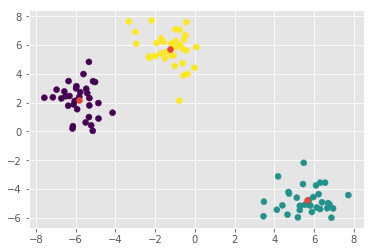

In [11]:
## Работоспособность MyKmeans++
mk = MyKmeans(k=3, init='k-means')
mk.fit(X)
plt.scatter(X[:,0], X[:, 1], c=mk.predict(X))
plt.scatter(mk.centroids[:, 0], mk.centroids[:, 1])

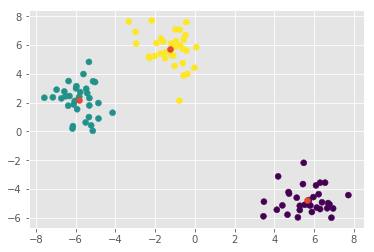

In [12]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
mbkm = MiniBatchKMeans(k=3)
mbkm.fit(X)
plt.scatter(X[:,0], X[:, 1], c=mbkm.predict(X))
plt.scatter(mbkm.centroids[:, 0], mbkm.centroids[:, 1])

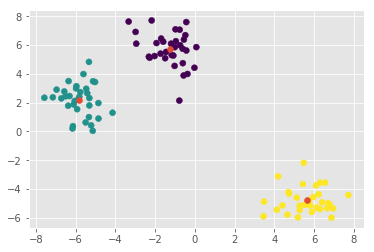

In [14]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
mbkm = MiniBatchKMeans(k=3, init='k-means')
mbkm.fit(X)
plt.scatter(X[:,0], X[:, 1], c=mbkm.predict(X))
plt.scatter(mbkm.centroids[:, 0], mbkm.centroids[:, 1])

In [15]:
## Время выполнения алгоритма Kmeans из sklearn
sk_kmeans = KMeans(n_clusters=3, init='random', max_iter=1000, precompute_distances=False, n_init=1)


%timeit sk_kmeans.fit(X)
pred = sk_kmeans.predict(X)

1.48 ms ± 464 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
## Время выполнения алгоритма MyKmeans
mk = MyKmeans(k=3)

%timeit mk.fit(X)
pred = mk.predict(X)

876 µs ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
## Время выполнения алгоритма MyKmeans++
mk = MyKmeans(k=3, init='k-means')

%timeit mk.fit(X)
pred = mk.predict(X)

1.08 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
mbkm = MiniBatchKMeans(k=3)

%timeit mbkm.fit(X)
pred = mbkm.predict(X)

942 µs ± 165 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
mbkm = MiniBatchKMeans(k=3, init='k-means')

%timeit mbkm.fit(X)
pred = mbkm.predict(X)

1.05 ms ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


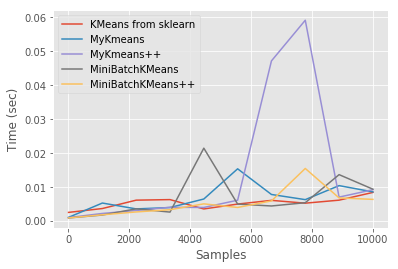

In [15]:
n_samples = np.linspace(10, 10000, 10, dtype=int)

results = []
for j, size in enumerate(n_samples):
    X, y = make_blobs(n_samples=size, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

    start = timeit.default_timer()
    model = KMeans(n_clusters=3, init='random', max_iter=1000, precompute_distances=False, n_init=1)
    model.fit(X)
    model.predict(X)
    results.append(timeit.default_timer() - start)
plt.plot(n_samples, results, label='KMeans from sklearn')
    
results = []
for j, size in enumerate(n_samples):
    X, y = make_blobs(n_samples=size, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    start = timeit.default_timer()
    model = MyKmeans(k=3)
    model.fit(X)
    model.predict(X)
    results.append(timeit.default_timer() - start)
plt.plot(n_samples, results, label='MyKmeans')
    
results = []
for j, size in enumerate(n_samples):
    X, y = make_blobs(n_samples=size, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    start = timeit.default_timer()
    model = MyKmeans(k=3, init='k-means')
    model.fit(X)
    model.predict(X)
    results.append(timeit.default_timer() - start)
plt.plot(n_samples, results, label='MyKmeans++')
    
results = []
for j, size in enumerate(n_samples):
    X, y = make_blobs(n_samples=size, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    start = timeit.default_timer()
    model = MiniBatchKMeans(k=3, batch_size=5)
    model.fit(X)
    model.predict(X)
    results.append(timeit.default_timer() - start)
plt.plot(n_samples, results, label='MiniBatchKMeans')
    
results = []
for j, size in enumerate(n_samples):
    X, y = make_blobs(n_samples=size, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    start = timeit.default_timer()
    model = MiniBatchKMeans(k=3, init='k-means', batch_size=5)
    model.fit(X)
    model.predict(X)
    results.append(timeit.default_timer() - start)
plt.plot(n_samples, results, label='MiniBatchKMeans++')


plt.xlabel('Samples')
plt.ylabel('Time (sec)')
plt.legend()
plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [24]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [25]:
df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis=1, inplace=True)
df_sns_work = (df_sns - df_sns.mean()) / df_sns.std()

In [28]:
X = df_sns_work.values

In [33]:
## MyKMeans
mk = MyKmeans(k=9)
mk.fit(X)
labels = mk.labels
df_sns['cluster'] = labels
for cluster in range(9):
    print("Cluster number %d:"%(cluster + 1))
    print(df_sns[df_sns['cluster'] == cluster].mean().T.sort_values(ascending=False))

Cluster number 1:
music           0.545879
god             0.313323
dance           0.215863
hair            0.181700
shopping        0.170866
band            0.163608
soccer          0.156143
rock            0.152411
cute            0.148263
basketball      0.135718
church          0.130845
die             0.122188
mall            0.116848
football        0.102177
sex             0.091861
sexy            0.083567
swimming        0.082063
death           0.076309
sports          0.073095
jesus           0.069051
tennis          0.066148
volleyball      0.059046
softball        0.054847
hot             0.052981
clothes         0.051322
cheerleading    0.046812
blonde          0.040747
dress           0.035925
kissed          0.031467
baseball        0.029653
drugs           0.021151
hollister       0.014619
abercrombie     0.009228
marching        0.009020
bible           0.003681
drunk           0.000000
cluster         0.000000
dtype: float64
Cluster number 2:
dance           1.231021

1 - музыка, бог, танцы(возможно религиозные) - скорее всего дети из религиозных общин, сект

2 - музыка, танцы, шоппинг - классические флексеры

3 - прически, секс, музыка - рэперы какие-то

4 - бог, объединение, Иисус - опять какие-то религиозные ребята

5 - спортсмены

6 - флексеры?

7 - работяги какие-то судя по гуглу

8 - снова спортсмены

9 - музыканты, судя по всему сами в группах, либо собирают


In [34]:
## MyKMeans++
mk = MyKmeans(k=9, init='k-means')
mk.fit(X)
labels = mk.labels
df_sns['cluster'] = labels
for cluster in range(9):
    print("Cluster number %d:"%(cluster + 1))
    print(df_sns[df_sns['cluster'] == cluster].mean().T.sort_values(ascending=False))

Cluster number 1:
hollister       1.510155
abercrombie     1.172043
shopping        0.923536
hair            0.915173
music           0.913978
dance           0.697730
mall            0.672640
cute            0.624851
god             0.471924
clothes         0.421744
football        0.405018
basketball      0.362007
hot             0.317802
cheerleading    0.314217
rock            0.293907
soccer          0.246117
volleyball      0.241338
sex             0.235364
church          0.234170
swimming        0.225806
blonde          0.223417
die             0.213859
sexy            0.203106
band            0.194743
dress           0.178017
sports          0.176822
softball        0.164875
death           0.155317
kissed          0.139785
baseball        0.111111
jesus           0.109916
drunk           0.105137
tennis          0.103943
drugs           0.076464
marching        0.014337
bible           0.008363
cluster         0.000000
dtype: float64
Cluster number 2:
god             5.222826

1 - работяги какие-то судя по гуглу

2 - религиозные ребята, возможно, сектанты

3 - спортсмены

4 - девочки, очевидно

5 - спортсмены

6 - флексеры

7 - верующие спортсмены

8 - снова спортсмены

9 - недоверуны

3, 5, 8  вообще одно и то же

In [36]:
## MyKMeans с MiniBatchMyKMeans
mk = MiniBatchKMeans(k=9)
mk.fit(X)
labels = mk.labels
df_sns['cluster'] = labels
for cluster in range(9):
    print("Cluster number %d:"%(cluster + 1))
    print(df_sns[df_sns['cluster'] == cluster].mean().T.sort_values(ascending=False))

Cluster number 1:
music           1.174768
dance           1.042265
shopping        0.962595
cute            0.874049
hair            0.711961
mall            0.638208
god             0.596577
church          0.473795
clothes         0.389687
rock            0.378276
swimming        0.359890
soccer          0.343195
sexy            0.310862
band            0.264159
die             0.238800
football        0.218090
sex             0.213863
basketball      0.209848
death           0.194632
tennis          0.174979
jesus           0.125740
blonde          0.119822
volleyball      0.118766
hot             0.104607
drunk           0.102071
sports          0.098478
dress           0.096999
kissed          0.091927
softball        0.087912
baseball        0.051775
hollister       0.050930
cheerleading    0.050719
drugs           0.044167
abercrombie     0.030854
bible           0.005072
marching        0.003593
cluster         0.000000
dtype: float64
Cluster number 2:
band            4.084337

1 - девоньки

2 - музыканты, возможно из группы, возможно, только собирают

3 - снова девахи

4 - спортсмены

5 - религиозные ребята

6 - опять девушки?

7 - сложные слова, похожи на работяг каких-то

8 - верующие

9 - девочки-чарлидирши

In [37]:
## MyKMeans++ с MiniBatchMyKMeans
mk = MiniBatchKMeans(k=9, init='k-means')
mk.fit(X)
labels = mk.labels
df_sns['cluster'] = labels
for cluster in range(9):
    print("Cluster number %d:"%(cluster + 1))
    print(df_sns[df_sns['cluster'] == cluster].mean().T.sort_values(ascending=False))

Cluster number 1:
music           0.524924
god             0.290756
dance           0.221462
hair            0.187973
shopping        0.174700
cute            0.159010
rock            0.149493
basketball      0.129842
die             0.121457
mall            0.119862
church          0.111014
soccer          0.108956
football        0.098925
sex             0.097845
band            0.093575
sexy            0.086527
swimming        0.078914
death           0.075107
sports          0.067236
tennis          0.065281
volleyball      0.064098
softball        0.059674
jesus           0.057719
hot             0.056433
clothes         0.053912
drunk           0.052163
cheerleading    0.047430
blonde          0.041720
dress           0.039148
kissed          0.033747
baseball        0.029631
drugs           0.021195
hollister       0.014970
abercrombie     0.009517
bible           0.005864
marching        0.001595
cluster         0.000000
dtype: float64
Cluster number 2:
hollister       1.515939

1 - верующие

2 - работяги

3 - музыканты

4 - снова музыканты

5 - девахи

6 - рэперы-флексеры

7 - спортсмены

8 - спортсмены

9 - спортсмены-музыканты

## Вывод
Результаты качества у всех моделей одинаковы.

Лучший результат у MyKMeans по времени, тем не менее на большом количестве сэмплов видно как время скачет.

И это можно объяснить отсутствием накладных расходов на подсчет начальной инициализации центроид.

У рандомной инициализации чуть страдает качество, но все равно результат хороший.

Стоит отметить, что модели с батчем показывают хорошее время и почти не скачут на примерах с большим количеством сэмплов. (чего не скажешь про MyKMeans++ без батча)
